# Quantization - Mateusz Cypcer
## Variant 3 - Ωc = sin(t), t ∈ [−1, 1] 

In [200]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import soundfile as sf  # requires 'pip install soundfile'

In [201]:
# quantization function

def my_quant(x, Q):
    r"""Saturated uniform midtread quantizer

    input:
    x  input signal
    Q  number of quantization steps
    output:
    xq quantized signal

    Note: for even Q in order to retain midtread characteristics,
    we must omit one quantization step, either that for lowest or the highest
    amplitudes. Typically the highest signal amplitudes are saturated to
    the 'last' quantization step. Then, in the special case of log2(N)
    being an integer the quantization can be represented with bits.
    """
    tmp = Q//2  # integer div
    quant_steps = (np.arange(Q) - tmp) / tmp  # we don't use this

    # forward quantization, round() and inverse quantization
    xq = np.round(x*tmp) / tmp
    # always saturate to -1
    xq[xq < -1.] = -1.
    # saturate to ((Q-1) - (Q\2)) / (Q\2), note that \ is integer div
    tmp2 = ((Q-1) - tmp) / tmp  # for odd N this always yields 1
    xq[xq > tmp2] = tmp2
    return xq

In [202]:
# cross corelation function

def my_xcorr2(x, y, scaleopt='none'):
    r""" Cross Correlation function phixy[kappa] -> x[k+kappa] y

    input:
    x   input signal shifted by +kappa
    y   input signal
    scaleopt   scaling of CCF estimator
    output:
    kappa   sample index
    ccf   correlation result
    """
    N = len(x)
    M = len(y)
    kappa = np.arange(0, N+M-1) - (M-1)
    ccf = signal.correlate(x, y, mode='full', method='auto')
    if N == M:
        if scaleopt == 'none' or scaleopt == 'raw':
            ccf /= 1
        elif scaleopt == 'biased' or scaleopt == 'bias':
            ccf /= N
        elif scaleopt == 'unbiased' or scaleopt == 'unbias':
            ccf /= (N - np.abs(kappa))
        elif scaleopt == 'coeff' or scaleopt == 'normalized':
            ccf /= np.sqrt(np.sum(x**2) * np.sum(y**2))
        else:
            print('scaleopt unknown: we leave output unnormalized')
    return kappa, ccf

In [203]:
# midtread quantizer function

def uniform_midtread_quantizer(x, deltaQ):
    r"""uniform_midtread_quantizer from the lecture:
    https://github.com/spatialaudio/digital-signal-processing-lecture/blob/master/quantization/linear_uniform_quantization_error.ipynb
    commit: b00e23e
    note: we renamed the second input to deltaQ, since this is what the variable
    actually represents, i.e. the quantization step size

    input:
    x   input signal to be quantized
    deltaQ    quantization step size
    output:
    xq   quantized signal
    """
    # [-1...1) amplitude limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - deltaQ)
    x[idx] = 1 - deltaQ
    # linear uniform quantization
    xq = deltaQ * np.floor(x/deltaQ + 1/2)
    return xq

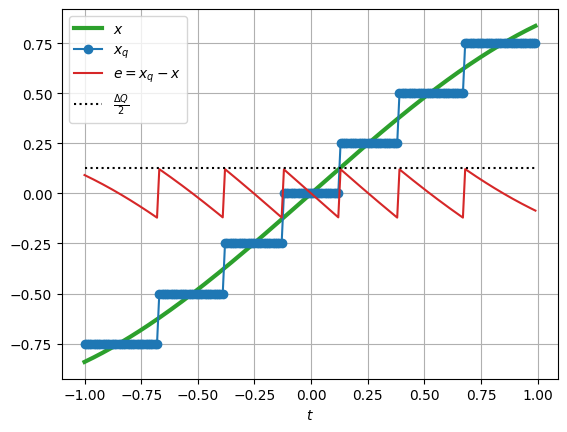

In [212]:
# signal quantization for Q = 9

Q = 9  # odd, number of quantization steps
t = np.arange(-1, 1, 0.01)
x = np.sin(t)
xq = my_quant(x, Q)
e = xq-x
# actually stem plots would be correct, for convenience we plot as line style
plt.plot(t, x, 'C2', lw=3, label=r'$x$')
plt.plot(t, xq, 'C0o-', label=r'$x_q$')
plt.plot(t, e, 'C3', label=r'$e=x_q-x$')
plt.plot(t, t*0+1/(Q-1), 'k:', label=r'$\frac{\Delta Q}{2}$')
plt.xlabel(r'$t$')
plt.legend()
plt.grid(True)

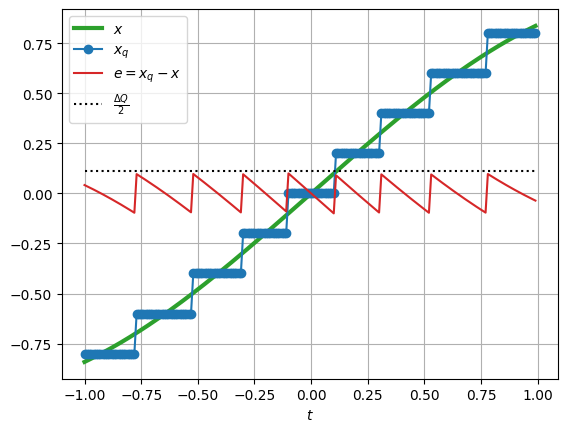

In [205]:
# signal quantization for Q = 10

Q = 10  # number of quantization steps
t = np.arange(-1, 1, 0.01)
x = np.sin(t)
xq = my_quant(x, Q)
e = xq-x
# actually stem plots would be correct, for convenience we plot as line style
plt.plot(t, x, 'C2', lw=3, label=r'$x$')
plt.plot(t, xq, 'C0o-', label=r'$x_q$')
plt.plot(t, e, 'C3', label=r'$e=x_q-x$')
plt.plot(t, t*0+1/(Q-1), 'k:', label=r'$\frac{\Delta Q}{2}$')
plt.xlabel(r'$t$')
plt.legend()
plt.grid(True)

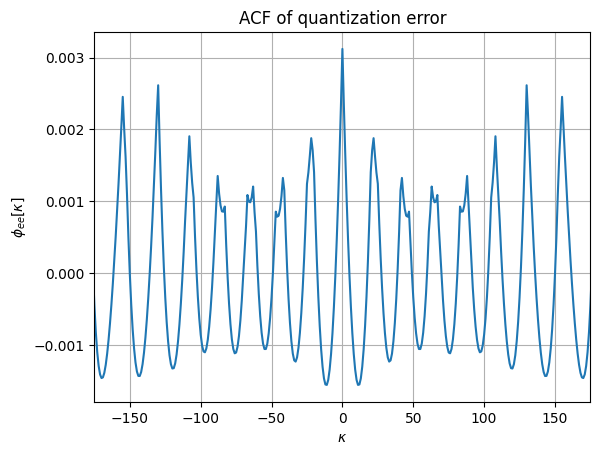

In [206]:
# Auto-correlation function

kappa, acf = my_xcorr2(e, e, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-175, +175)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{ee}[\kappa]$')
plt.title('ACF of quantization error')
plt.grid(True)

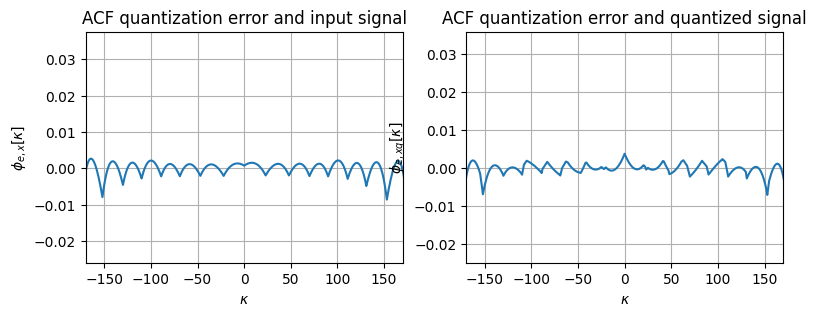

In [207]:
plt.figure(figsize=(9, 3))

plt.subplot(1, 2, 1)
kappa, acf = my_xcorr2(e, x, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-170, +170)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{e,x}[\kappa]$')
plt.title('ACF quantization error and input signal')
plt.grid(True)

plt.subplot(1, 2, 2)
kappa, acf = my_xcorr2(e, xq, 'unbiased')
plt.plot(kappa, acf)
plt.xlim(-170, +170)
plt.xlabel(r'$\kappa$')
plt.ylabel(r'$\phi_{e,xq}[\kappa]$')
plt.title('ACF quantization error and quantized signal')
plt.grid(True)

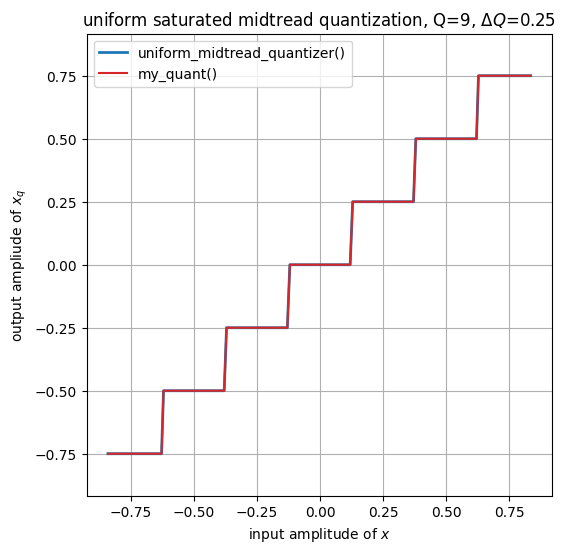

In [208]:
# midtread quantization for Q = 9

Q = 9  # number of quantization steps, odd or even
deltaQ = 1/(Q//2)  # quantization step size, even/odd Q

xq = my_quant(x, Q)  # used in exercise
xumq = uniform_midtread_quantizer(x, deltaQ)  # as used in lecture

plt.figure(figsize=(6, 6))
plt.plot(x, xumq, 'C0', lw=2, label='uniform_midtread_quantizer()')
plt.plot(x, xq, 'C3', label='my_quant()')
plt.xticks(np.arange(-1, 1.25, 0.25))
plt.yticks(np.arange(-1, 1.25, 0.25))
plt.xlabel(r'input amplitude of $x$')
plt.ylabel(r'output ampliude of $x_q$')
plt.title(
    r'uniform saturated midtread quantization, Q={0:d}, $\Delta Q$={1:3.2f}'.format(Q, deltaQ))
plt.axis('equal')
plt.legend()
plt.grid(True)

In [209]:
# saturation

def check_my_quant(Q):
    N = 5e2
    x = 2*np.arange(N)/N - 1
    xq = my_quant(x, Q)
    e = xq - x

    plt.plot(x, x, color='C2', lw=3, label=r'$x[k]$')
    plt.plot(x, xq, color='C3', label=r'$x_q[k]$')
    plt.plot(x, e, color='C0', label=r'$e[k] = x_q[k] - x[k]$')
    plt.xticks(np.arange(-1, 1.25, 0.25))
    plt.yticks(np.arange(-1, 1.25, 0.25))
    plt.xlabel('input amplitude')
    plt.ylabel('output amplitude')
    if np.mod(Q, 2) == 0:
        s = ' saturated '
    else:
        s = ' '
    plt.title(
        'uniform'+s+'midtread quantization with Q=%d steps, $\Delta Q$=%4.3e' % (Q, 1/(Q//2)))
    plt.axis('equal')
    plt.legend(loc='upper left')
    plt.grid(True)

<>:19: SyntaxWarning: invalid escape sequence '\D'
<>:19: SyntaxWarning: invalid escape sequence '\D'
C:\Users\student\AppData\Local\Temp\ipykernel_14920\1613999847.py:19: SyntaxWarning: invalid escape sequence '\D'
  'uniform'+s+'midtread quantization with Q=%d steps, $\Delta Q$=%4.3e' % (Q, 1/(Q//2)))


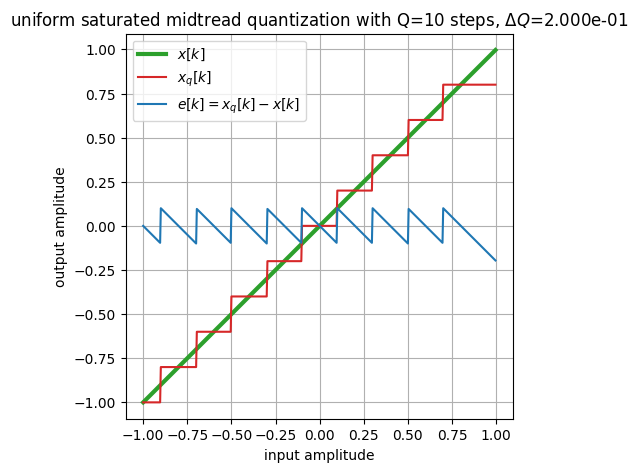

In [210]:
Q = 10  # number of quantization steps
deltaQ = 1 / (Q//2)  # general rule
deltaQ = 2 / (Q-1)  # for odd Q only
plt.figure(figsize=(5, 5))
check_my_quant(Q)